# Analyses on "Not an experience" text data
The aim is to identify features that can help to build a robust model to classify comments that do not describe an experience

This notebook investigates the dataset used to train a model, which classifies NHS.uk reviews into two categories: actual experiences with NHS services and general comments, or "Not an Experience" (NAE). We had already explored a method combining embeddings and classifiers, but we're now looking for potentially better ways to do this by going back to the basics. We've started by closely examining our data to better understand these two kinds of reviews and their "non-semantic" meaning.

We divided the reviews into "Experience" (those that were published) and "Not Experience" (flagged by our expert moderators). Our aim is to spot differences between them by looking at things like which words are often used together, how long the reviews are, the grammar used, the use of pronouns, and the sentiment of the text. This will help us figure out if non-semantic approaches like Bag of Words or TF-IDF could be useful in identifying real experiences from generic comments.


In [ ]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import en_core_web_trf

## Load data

In [1]:

# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = # REDACTED
resource_group = # REDACTED
workspace_name = # REDACTED

workspace = Workspace(subscription_id, resource_group, workspace_name)

In [2]:
dataset = Dataset.get_by_name(workspace, name='published_3k_DG_devset')
published_df = dataset.to_pandas_dataframe()
# Add a new column called "label" with values of 0 using the assign() method
published_df = published_df.assign(label=0)
published_df = published_df.sample(1000)

dataset = Dataset.get_by_name(workspace, name='not_an_experience_1000_Oct23_Finola')
nae_df = dataset.to_pandas_dataframe()

# Concatenate the dataframes
combined_df = pd.concat([nae_df, published_df], axis=0, ignore_index=True)

# Ensure the columns are only "Comment ID", "Comment Text", and "label"
combined_df = combined_df[["Comment ID", "Comment Text", "label"]]

# Term frequency analysis

In [39]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.7.2/en_core_web_trf-3.7.2.tar.gz

## Spacy n-grams

In [43]:
# Load tokenizer
spacy_nlp = spacy.load('en_core_web_trf')

In [44]:
# Data Preprocessing with spaCy
def preprocess(text):
    doc = spacy_nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

combined_df['tokenized'] = combined_df['Comment Text'].apply(preprocess)

In [46]:
# Extract N-grams with spaCy (bigrams for this example)
def extract_bigrams(tokens):
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

combined_df['bigrams'] = combined_df['tokenized'].apply(extract_bigrams)

In [47]:
# Count Frequencies
experience_bigrams = combined_df[combined_df['label'] == 0]['bigrams'].explode().value_counts()
not_experience_bigrams = combined_df[combined_df['label'] == 1]['bigrams'].explode().value_counts()

In [49]:
# Filter & Find Differences
threshold = 15   
popular_not_experience = not_experience_bigrams[not_experience_bigrams > threshold]
less_popular_experience =  experience_bigrams[experience_bigrams <= threshold] 

difference_bigrams = popular_not_experience.index.difference(less_popular_experience.index) #The index.difference() returns a new index object with the elements of the first index that are not in the second index.
result_bigrams = popular_not_experience.loc[difference_bigrams]

In [50]:
# Create a DataFrame with Bigram, Not Experience Frequency, and Experience Frequency
result_df = pd.DataFrame({
    'Bigram': result_bigrams.index,
    'Not Experience Frequency': result_bigrams.values
})

def get_experience_frequency(bigram):
    return experience_bigrams.get(bigram, 0)

result_df['Experience Frequency'] = result_df['Bigram'].apply(get_experience_frequency)

In [56]:
result_df['diff'] = result_df['Not Experience Frequency'] - result_df['Experience Frequency']
result_df.sort_values('diff', ascending=False, inplace=True)

In [57]:
result_df

,Bigram,Not Experience Frequency,Experience Frequency,diff
8,"(practice, year)",61,19,42
2,"(doctor, nurse)",40,17,23
7,"(mental, health)",31,17,14
9,"(reception, staff)",56,48,8
11,"(staff, friendly)",34,32,2
5,"(friendly, helpful)",25,25,0
10,"(service, receive)",18,19,-1
4,"(feel, like)",16,17,-1
0,"(blood, test)",18,22,-4
3,"(face, face)",29,35,-6


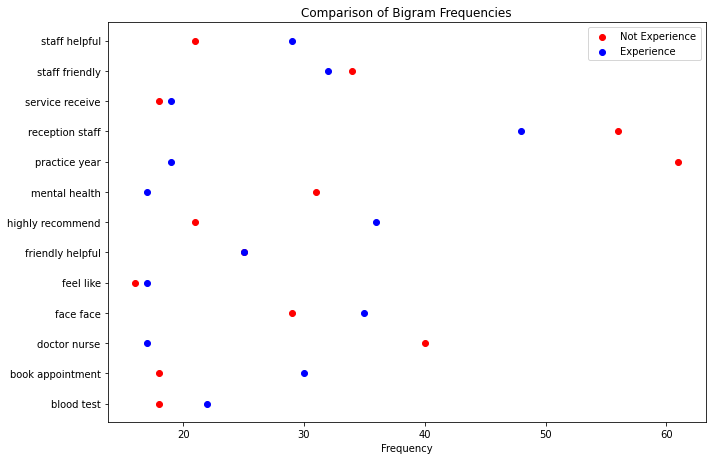

In [58]:
# Sort
result_df = result_df.sort_values(by='diff', ascending=True)

# Setting up the figure and axis
fig, ax = plt.subplots(figsize=(10, len(result_df) * 0.5))  # Adjust size based on number of bigrams

ax.scatter(result_df['Not Experience Frequency'], result_df.index, color='red', label='Not Experience')
ax.scatter(result_df['Experience Frequency'], result_df.index, color='blue', label='Experience')


# Setting labels for the y-axis
ax.set_yticks(result_df.index)
ax.set_yticklabels([' '.join(bigram) for bigram in result_df['Bigram']], fontsize=10)
ax.set_xlabel('Frequency')

# Display legend and title
ax.legend()
ax.set_title('Comparison of Bigram Frequencies')

plt.tight_layout()
plt.show()


## differences in tense and pronouns between the two sets
1. Tokenization and POS tagging using spaCy: Extract verbs and pronouns.
2. Count Frequencies of Verbs, Tenses, and Pronouns.
3. Identify Key Differences.

In [69]:
df = combined_df

# 1. Tokenization and POS tagging using spaCy
def extract_features(text):
    doc = spacy_nlp(text.lower())
    tenses = [token.tag_ for token in doc if "VERB" in token.pos_]
    pronouns = [token.lemma_ for token in doc if "PRON" in token.pos_]
    return tenses, pronouns

df['tenses'], df['pronouns'] = zip(*df['Comment Text'].apply(extract_features))

# 2. Count Frequencies of Tenses and Pronouns
experience_tenses = df[df['label'] == 0]['tenses'].explode().value_counts()
not_experience_tenses = df[df['label'] == 1]['tenses'].explode().value_counts()

experience_pronouns = df[df['label'] == 0]['pronouns'].explode().value_counts()
not_experience_pronouns = df[df['label'] == 1]['pronouns'].explode().value_counts()

# 3. Identify Key Differences
diff_tenses = not_experience_tenses.subtract(experience_tenses, fill_value=0).sort_values(ascending=False).head(10)
diff_pronouns = not_experience_pronouns.subtract(experience_pronouns, fill_value=0).sort_values(ascending=False).head(10)

# 4. Prepare a DataFrame for tenses
tenses_df = pd.DataFrame({
    'Tense': not_experience_tenses.index,
    'Not Experience Frequency': not_experience_tenses.values,
    'Experience Frequency': experience_tenses[not_experience_tenses.index].fillna(0).astype(int).values
}).sort_values(by='Not Experience Frequency', ascending=True)  # Sorting for a better visualization

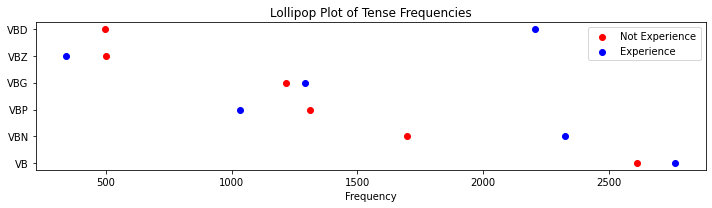

In [70]:
# Visualize Tenses 
fig, ax = plt.subplots(figsize=(10, len(tenses_df) * 0.5))

ax.scatter(tenses_df['Not Experience Frequency'], tenses_df.index, color='red', label='Not Experience')

ax.scatter(tenses_df['Experience Frequency'], tenses_df.index, color='blue', label='Experience')

ax.set_yticks(tenses_df.index)
ax.set_yticklabels(tenses_df['Tense'], fontsize=10)
ax.set_xlabel('Frequency')
ax.legend()
ax.set_title('Comparison of Tense Frequencies')

plt.tight_layout()
plt.show()


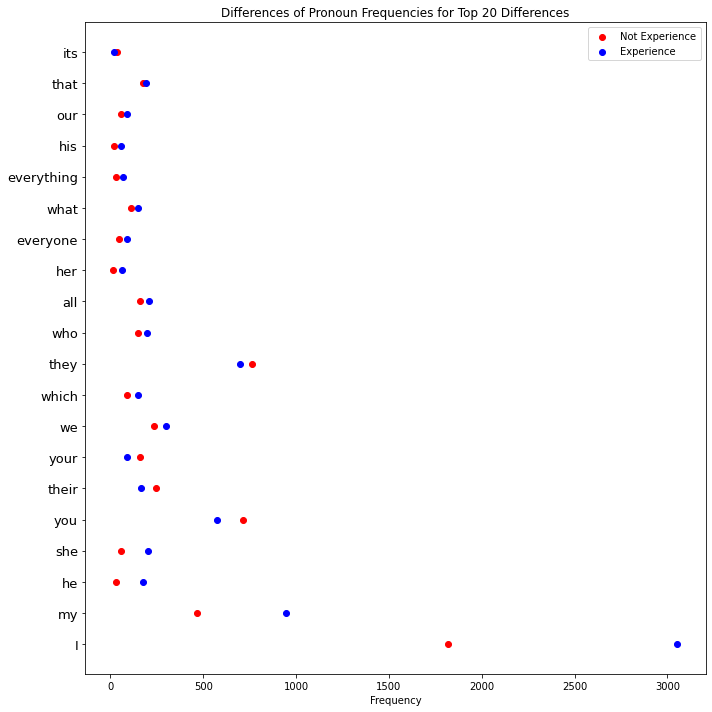

In [73]:
# 1. Calculate the Difference
pronoun_diff = (not_experience_pronouns - experience_pronouns).dropna()

# 2. Select Top 20 pronouns with biggest differences
top_diff_pronouns = pronoun_diff.abs().nlargest(20).index

# 3. Prepare DataFrame
pronouns_df = pd.DataFrame({
    'Pronoun': top_diff_pronouns,
    'Not Experience Frequency': not_experience_pronouns[top_diff_pronouns].fillna(0).astype(int).values,
    'Experience Frequency': experience_pronouns[top_diff_pronouns].fillna(0).astype(int).values
}).sort_values(by='Not Experience Frequency', ascending=True)  # Sorting for better visualization

# 4. Plot Lollipop for Pronouns
fig, ax = plt.subplots(figsize=(10, len(pronouns_df) * 0.5))

ax.scatter(pronouns_df['Not Experience Frequency'], pronouns_df.index, color='red', label='Not Experience')
ax.scatter(pronouns_df['Experience Frequency'], pronouns_df.index, color='blue', label='Experience')

ax.set_yticks(pronouns_df.index)
ax.set_yticklabels(pronouns_df['Pronoun'], fontsize=13)
ax.set_xlabel('Frequency')
ax.legend()
ax.set_title('Differences of Pronoun Frequencies for Top 20 Differences')

plt.tight_layout()
plt.show()


# Sentiment

In [6]:
# pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [33]:

# Analyzing sentiment of the texts
def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity  # polarity ranges from -1 (most negative) to 1 (most positive)

combined_df['sentiment'] = combined_df['Comment Text'].apply(analyze_sentiment)

# Calculating average sentiment for each group
average_sentiment_experience = combined_df[combined_df['label'] == 0]['sentiment'].mean()
average_sentiment_not_experience = combined_df[combined_df['label'] == 1]['sentiment'].mean()

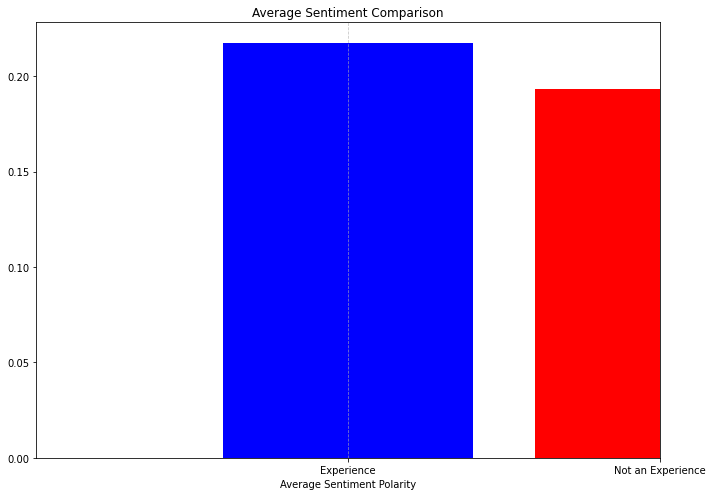

In [9]:
# Visualizing the results
labels = ['Experience', 'Not an Experience']
values = [average_sentiment_experience, average_sentiment_not_experience]

plt.figure(figsize=(10, 7))
plt.bar(labels, values, color=['blue', 'red'])
plt.xlabel('Average Sentiment Polarity')
plt.title('Average Sentiment Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(-1, 1)  # since polarity ranges from -1 to 1
plt.tight_layout()
plt.show()

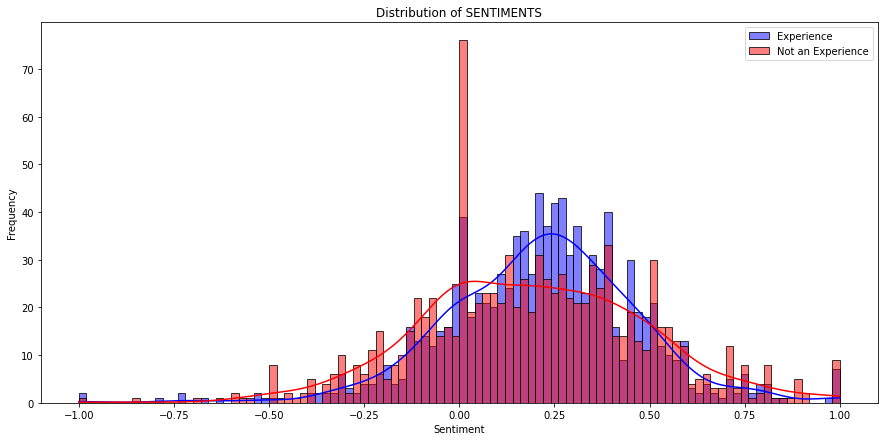

In [34]:
# Histogram

plt.figure(figsize=(15, 7))

# Experience
sns.histplot(combined_df[combined_df['label'] == 0]['sentiment'], color="blue", label="Experience", kde=True, bins=100, alpha=0.5)

# Not an Experience
sns.histplot(combined_df[combined_df['label'] == 1]['sentiment'], color="red", label="Not an Experience", kde=True, bins=100, alpha=0.5)

plt.title('Distribution of SENTIMENTS')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Length

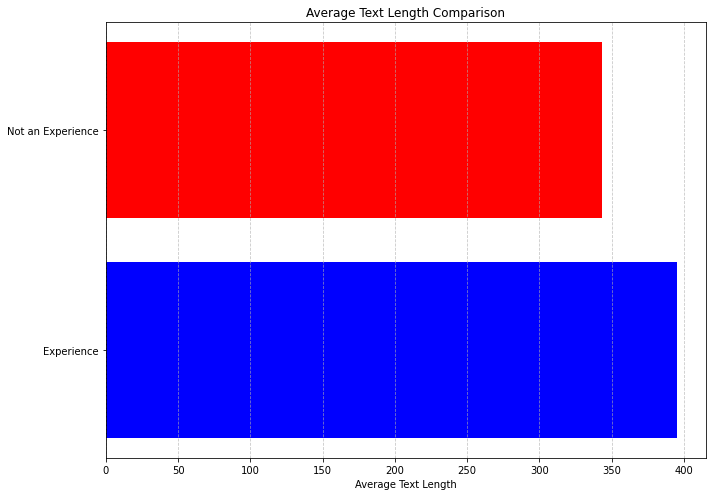

In [10]:
# 1. Calculate the length of each text
combined_df['text_length'] = combined_df['Comment Text'].apply(len)

# 2. Calculate average length for each group
average_length_experience = combined_df[combined_df['label'] == 0]['text_length'].mean()
average_length_not_experience = combined_df[combined_df['label'] == 1]['text_length'].mean()



labels = ['Experience', 'Not an Experience']
values = [average_length_experience, average_length_not_experience]

plt.figure(figsize=(10, 7))
plt.barh(labels, values, color=['blue', 'red'])
plt.xlabel('Average Text Length')
plt.title('Average Text Length Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

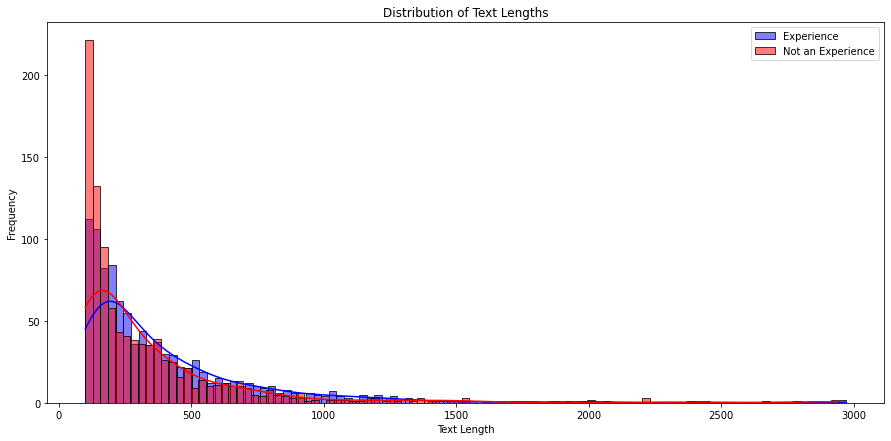

In [13]:
# Histogram
plt.figure(figsize=(15, 7))

# Experience
sns.histplot(combined_df[combined_df['label'] == 0]['text_length'], color="blue", label="Experience", kde=True, bins=100, alpha=0.5)

# Not an Experience
sns.histplot(combined_df[combined_df['label'] == 1]['text_length'], color="red", label="Not an Experience", kde=True, bins=100, alpha=0.5)

plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

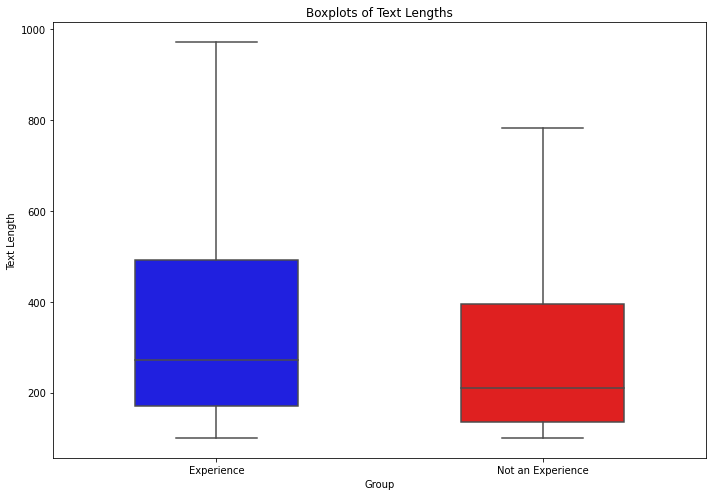

In [15]:
# box plots

plt.figure(figsize=(10, 7))
sns.boxplot(x='label', y='text_length', data=combined_df, palette={0: 'blue', 1: 'red'}, width=0.5, showfliers=False,) #hiding outliers
plt.title('Boxplots of Text Lengths')
plt.xlabel('Group')
plt.ylabel('Text Length')
plt.xticks(ticks=[0, 1], labels=["Experience", "Not an Experience"])
plt.tight_layout()
plt.show()